## Image segmentation with CamVid

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

The One Hundred Layer Tiramisu paper used a modified version of Camvid, with smaller images and few classes. You can get it from the CamVid directory of this repo:

    git clone https://github.com/alexgkendall/SegNet-Tutorial.git

In [5]:
!git clone https://github.com/alexgkendall/SegNet-Tutorial.git

Cloning into 'SegNet-Tutorial'...
remote: Enumerating objects: 2785, done.
remote: Total 2785 (delta 0), reused 0 (delta 0), pack-reused 2785
Receiving objects: 100% (2785/2785), 340.84 MiB | 35.65 MiB/s, done.
Resolving deltas: 100% (81/81), done.


In [0]:
path = Path('./SegNet-Tutorial/CamVid') #Path('./data/camvid-tiramisu')

In [14]:
path.ls()

[PosixPath('SegNet-Tutorial/CamVid/train'),
 PosixPath('SegNet-Tutorial/CamVid/train.txt'),
 PosixPath('SegNet-Tutorial/CamVid/test'),
 PosixPath('SegNet-Tutorial/CamVid/testannot'),
 PosixPath('SegNet-Tutorial/CamVid/trainannot'),
 PosixPath('SegNet-Tutorial/CamVid/val.txt'),
 PosixPath('SegNet-Tutorial/CamVid/valannot'),
 PosixPath('SegNet-Tutorial/CamVid/val'),
 PosixPath('SegNet-Tutorial/CamVid/test.txt')]

## Data

In [15]:
fnames = get_image_files(path/'val')
fnames[:3]

[PosixPath('SegNet-Tutorial/CamVid/val/0016E5_08127.png'),
 PosixPath('SegNet-Tutorial/CamVid/val/0016E5_08077.png'),
 PosixPath('SegNet-Tutorial/CamVid/val/0016E5_08135.png')]

In [16]:
lbl_names = get_image_files(path/'valannot')
lbl_names[:3]

[PosixPath('SegNet-Tutorial/CamVid/valannot/0016E5_08127.png'),
 PosixPath('SegNet-Tutorial/CamVid/valannot/0016E5_08077.png'),
 PosixPath('SegNet-Tutorial/CamVid/valannot/0016E5_08135.png')]

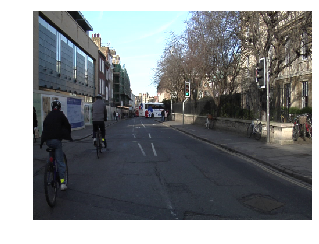

In [17]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
    'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

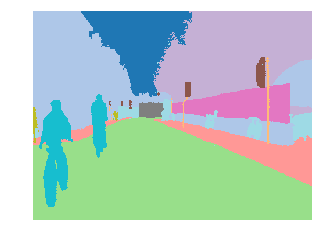

In [19]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [20]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([360, 480]), tensor([[[1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          ...,
          [3, 3, 3,  ..., 3, 3, 3],
          [3, 3, 3,  ..., 3, 3, 3],
          [3, 3, 3,  ..., 3, 3, 3]]]))

## Datasets

In [0]:
bs,size = 8,src_size//2

In [0]:
src = (SegmentationItemList.from_folder(path)
       .split_by_folder(valid='val')
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

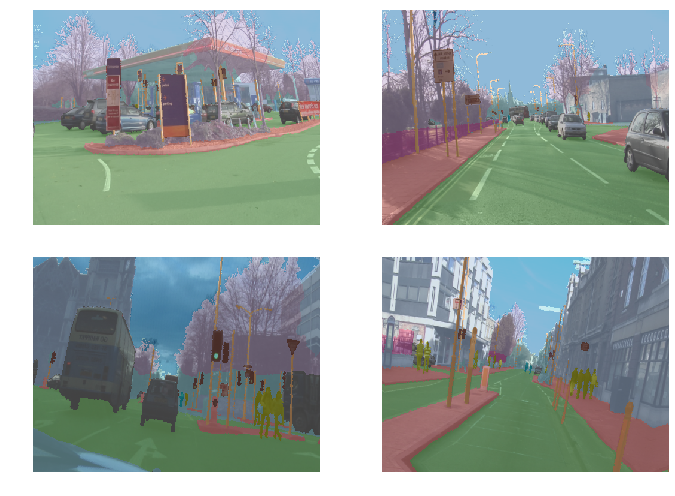

In [24]:
data.show_batch(2, figsize=(10,7))

## Model

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid
wd=1e-2

In [27]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:03<00:00, 22716322.40it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


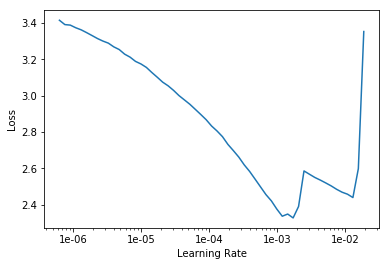

In [28]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=5e-4

In [30]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.849747,1.349640,0.626546,01:54
1,1.130511,0.788170,0.824882,01:43
2,0.782964,0.599084,0.845303,01:43
3,0.625505,0.471998,0.865959,01:43
4,0.536254,0.456953,0.858364,01:43
5,0.507291,0.434009,0.876708,01:43
6,0.433308,0.360431,0.886897,01:43
7,0.402804,0.307676,0.902977,01:42
8,0.358814,0.313591,0.896897,01:42
9,0.316013,0.280664,0.914373,01:43


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/100,lr)

In [35]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.274338,0.280314,0.911987,01:48
1,0.267269,0.272928,0.919927,01:47
2,0.263095,0.267199,0.920498,01:47
3,0.258298,0.286151,0.914895,01:47
4,0.273142,0.289116,0.916189,01:47
5,0.277951,0.425638,0.861643,01:47
6,0.285896,0.251698,0.924156,01:47
7,0.278894,0.287703,0.916805,01:47
8,0.280860,0.307686,0.912377,01:47
9,0.264297,0.257852,0.924811,01:47


In [0]:
learn.save('stage-2');

## Go big

In [37]:
learn=None
gc.collect()

42

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [0]:
size = src_size
bs=4

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True).load('stage-2').to_fp16();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


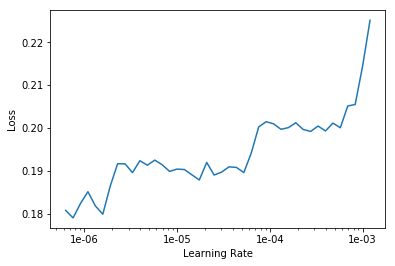

In [41]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=1e-4

In [43]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.194221,0.236714,0.930452,02:10
1,0.197024,0.237988,0.930919,02:00
2,0.194620,0.232884,0.931665,02:00
3,0.192695,0.231939,0.931416,02:00
4,0.191619,0.252469,0.928077,02:00
5,0.188445,0.249023,0.928452,02:01
6,0.186312,0.229568,0.935417,02:01
7,0.179503,0.241380,0.931478,02:00
8,0.175375,0.228439,0.931952,02:01
9,0.164739,0.233057,0.933398,02:01


In [0]:
learn.save('stage-1-big')

In [0]:
learn.load('stage-1-big');

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/1000,lr/10)

In [48]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.162220,0.232018,0.933931,02:08
1,0.161876,0.229243,0.934382,02:08
2,0.161964,0.230967,0.934131,02:07
3,0.164232,0.236243,0.933487,02:08
4,0.163717,0.235502,0.933375,02:07
5,0.158554,0.229483,0.934648,02:08
6,0.158094,0.231026,0.934538,02:07
7,0.156758,0.229773,0.934520,02:08
8,0.155734,0.230326,0.934646,02:07
9,0.155496,0.231104,0.934207,02:08


In [0]:
learn.save('stage-2-big')

In [0]:
learn.load('stage-2-big');

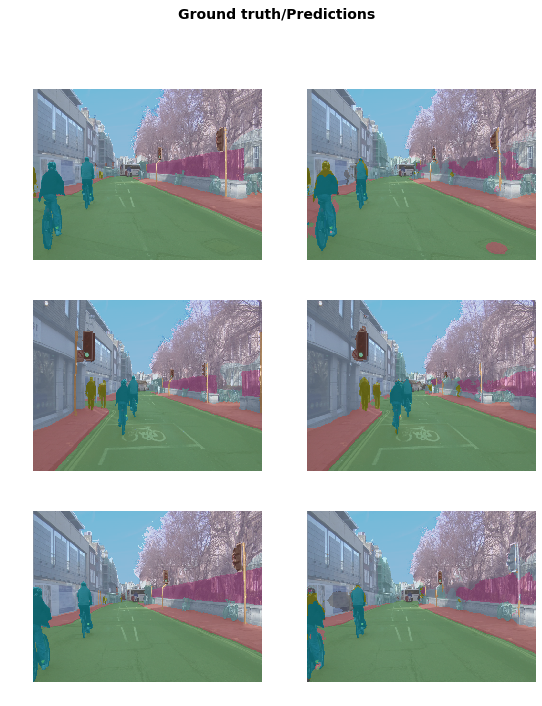

In [51]:
learn.show_results(rows=3, figsize=(9,11))

## fin

In [0]:
# start: 480x360

In [0]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 64, 180, 240]    9408       False     
______________________________________________________________________
BatchNorm2d          [8, 64, 180, 240]    128        True      
______________________________________________________________________
ReLU                 [8, 64, 180, 240]    0          False     
______________________________________________________________________
MaxPool2d            [8, 64, 90, 120]     0          False     
______________________________________________________________________
Conv2d               [8, 64, 90, 120]     36864      False     
______________________________________________________________________
BatchNorm2d          [8, 64, 90, 120]     128        True      
______________________________________________________________________
ReLU                 [8, 64, 90, 120]     0          False     
______________________________________________________________